# Practical: Rhythm Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muprocdurham as mpd
import muprocdurham.sound as mps
from pitchtypes import Enharmonic

mpd.seed_everything(42)

## Playing a Rhythm

Let's start by playing some simple rhythm. It's just more fun if you can hear stuff :)

You can get royalty-free samples here:
- bass drum: https://soundcamp.org/tag/tuned-kick-drums
- snare drum: https://soundcamp.org/drum-samples-loops-and-one-shots/drum-single-hits-one-shots/snare-drum-samples/
- hi-hat: https://soundcamp.org/tag/hip-hop-hi-hat

In [2]:
bass_drum = mps.load('bass_drum.wav')
snare_drum = mps.load('snare_drum.wav')
hi_hat = mps.load('hi_hat.wav')
mps.audio(bass_drum)
mps.audio(snare_drum)
mps.audio(hi_hat)

You can use the `audio_add` function to build a rhythm from these samples (use `min_total_time=10` to generate a sufficiently large audio buffer in the first call to avoid repeated extension if required). The following creates a simple backbeat (snare on 2 and 4):

In [3]:
audio = None
for i in range(16):  # 16 beats --> 8th notes if we generate two measures
    # beat every 250ms
    t = i / 4
    # bass drum every four beats (half notes)
    if i % 4 == 0:
        audio = mps.audio_add(wave=bass_drum, start_time=t, audio=audio)
    # snare drum every four beats but shifted by 2 (backbeat)
    if (i + 2) % 4 == 0:
        audio = mps.audio_add(wave=snare_drum, start_time=t, audio=audio)
    # hi-hat on all events (i.e. one additional between bass and snare)
    audio = mps.audio_add(hi_hat, t, audio)
mps.audio(audio)

You can play around a bit and try to generate nice grooves!

## Generating Rhythms

### Random

We can start by generating random events on an isochronous (uniform in time) grid.

In [4]:
audio = None
for i in range(32):
    # vvvvvvvvvvvvvvv
    t = i / 4
    # bass drum
    if np.random.rand() < 0.2:
        audio = mps.audio_add(bass_drum, t, audio)
    # snare
    if np.random.rand() < 0.2:
        audio = mps.audio_add(snare_drum, t, audio)
    # hi-hat
    if np.random.rand() < 0.5:
        audio = mps.audio_add(hi_hat, t, audio)
    # ^^^^^^^^^^^^^^^^
mps.audio(audio)

This is somewhat interesting because we feel the underlying isochronous grid, but it feels a bit chaotic.

### Generate Metrical Weights Top-Down

As an alternative, we can start by generating metrical weights. In the lecture, we have seen two (very similar) ways of generating metrical weights top-down by repeatedly splitting an element
1. Counting Opportunities
   - We start from a single element with weight one.
   - We generate new elements by splitting an existing element with weight `w` into two elements with weights `w'` and `w''`.
   - The first weight "counts up" (i.e. it keeps track of the number of opportunities to stop splitting), while the second is initialised with 1.
2. By Depth (the deper an element is created, the lower its weight)
   - We start with the maximum possible weight (the number of splits + 1)
   - New pairs of weights are created by keeping the weight for the first element and initialising the second with `max_weight - depth`.
   - **Hint:** `max_weight` is used in all weights like an offset, you can instead start with zero weight, go negative (`-depth`) and later add the offset to get positive weights.

In [5]:
def generate_weights(
    n_splits, # how often to split (also defines the maximum weight)
    count=True, # whether to compute weights by "counting opportunities" or by depth
    start_from_zero=False, # whether to start from zero when using depth
    verbose=False,
):
    max_weight = n_splits + 1

    # initialise first weight
    weights = []
    if count:
        # vvvvvvvvvvvvvvvv
        weights.append(1)
        # ^^^^^^^^^^^^^^^^
    else:
        # vvvvvvvvvvvvvvvv
        if start_from_zero:
            weights.append(0)
        else:
            weights.append(max_weight)
        # ^^^^^^^^^^^^^^^^
    
    # repeatedly split
    for depth in range(1, n_splits + 1):
        new_weights = []
        for w in weights:
            if count:
                # count opportunities to stop splitting
                # vvvvvvvvvvvvvvvvvvvvvvvv
                new_weights += [w + 1, 1]
                # ^^^^^^^^^^^^^^^^^^^^^^^^
            else:
                # set new weights according to (negative) depth where they are created
                # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                if start_from_zero:
                    new_weights += [w, - depth]
                else:
                    new_weights += [w, max_weight - depth]
                # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        weights = np.array(new_weights)
        if verbose:
            print(weights)

    # if starting from zero weight
    if not count and start_from_zero:
        # vvvvvvvvvvvvvvvvvvv
        weights += max_weight
        # ^^^^^^^^^^^^^^^^^^^
        
    return weights

print("Weights by counting:")
print(generate_weights(5, count=True, verbose=True))
print("Weights via depth:")
print(generate_weights(5, count=False, verbose=True))
print("Weights via depth (starting from zero):")
print(generate_weights(5, count=False, verbose=True, start_from_zero=True))

Weights by counting:
[2 1]
[3 1 2 1]
[4 1 2 1 3 1 2 1]
[5 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1]
[6 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1 5 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1]
[6 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1 5 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1]
Weights via depth:
[6 5]
[6 4 5 4]
[6 3 4 3 5 3 4 3]
[6 2 3 2 4 2 3 2 5 2 3 2 4 2 3 2]
[6 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1 5 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1]
[6 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1 5 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1]
Weights via depth (starting from zero):
[ 0 -1]
[ 0 -2 -1 -2]
[ 0 -3 -2 -3 -1 -3 -2 -3]
[ 0 -4 -3 -4 -2 -4 -3 -4 -1 -4 -3 -4 -2 -4 -3 -4]
[ 0 -5 -4 -5 -3 -5 -4 -5 -2 -5 -4 -5 -3 -5 -4 -5 -1 -5 -4 -5 -3 -5 -4 -5
 -2 -5 -4 -5 -3 -5 -4 -5]
[6 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1 5 1 2 1 3 1 2 1 4 1 2 1 3 1 2 1]


You can already turn this into a beat by thresholding on the weight (above a certain weight play bass drum, below a certain weight hi-hat, in between snare). In fact, you can easily reproduce the backbeat pattern from above with this.

In [6]:
def beat_from_weights(weights):
    audio = None
    for i, w in enumerate(weights):
        # vvvvvvvvvvvvvvv
        t = i / 4
        # ignore zero weights (for later)
        if w <= 0:
            pass
        # bass drum
        elif w >= 3:
            audio = mps.audio_add(bass_drum, t, audio)
        # hi-hat
        elif w <= 1:
            audio = mps.audio_add(hi_hat, t, audio)
        # snare
        else:
            audio = mps.audio_add(snare_drum, t, audio)
        # ^^^^^^^^^^^^^^^
    return audio
mps.audio(beat_from_weights(generate_weights(4)))

### Generating a Rhythm via Independent Sampling 

To make things a bit more interesting, we can add some randomness by generating events independently based on the metrical weights, as we know the metrical weights are porportional to the log-probability of observing an event at that location (when generating with a grammar).

**Important:** This does not take into account the dependencies between different events, so this is an appoximation!
- Take the weights [3 1 2 1]. We have two ways of generating an event at position 2 (we can split once or twice), but only one of these (splitting twice) also generates an event at position 4 (this is the _only_ way we can generate an event at position 4). Hence, we _can_ generate an event at position 3 but not 4 (by splitting only once), but we _cannot_ generate an event at position 4 but not 3 (because we need to split twice). These two event are thus not independent, if there is an event on 4, there _has_ to be one at 3, too.

Nevertheless, it can produce nice rhythms that are not deterministic but better than randomly sampling events. In the lecture we saw that the probability $\bar{p}_d$ for generating an event at depth $d$ is

$\bar{p}_d = p_s^{w_0 - w_d} \, \frac{p_b}{p_b + p_r}$

where $w_d$ is the corresponding metrical weight, $w_0$ is the maximum weight, $p_s$ is the probability to split, and $p_b$ and $p_r$ are the probabilities to generate a beat or rest, respectively. If we ignore rests ($p_r=0$), as these will natually appear from the sampling, this simplifies to

$\bar{p}_d = p_s^{w_0 - w_d}$

so we can compute this directly from the metrical weight and a fixed splitting probability $p_s$ that acts as an overall scalling contant. Use this to sample events independently based on their metrical weight. Return an array that contains the corresponding metrical weight for a beat or zero otherwise.

In [7]:
def sample_by_weights(n_splits, ps=0.9):
    weights = generate_weights(n_splits)
    # vvvvvvvvvvvvv
    probs = ps ** (n_splits + 1 - weights)
    beats = (probs > np.random.random_sample(probs.shape)) * weights
    # ^^^^^^^^^^^^^
    return beats

mps.audio(beat_from_weights(sample_by_weights(5)))

## Rhythm Grammar

Using a rhythm grammar ensures that different events are coordinated. It generates rhythms by applying three possible operations:
- `split` an existing time interval into two intervals of half the `duration`
- fill an existing time interval with a `beat` (the interval cannot be split anymore afterwards)
- fill an existing time interval with a `rest` (the interval cannot be split anymore afterwards)

These are applied with probabilities `p_split`, `p_beat`, and `p_rest` (`p_split + p_beat + p_rest = 1`), respectively.

Additionally, we would also like to keep track of the metrical weight of a particular interval. You can use the `TimeInterval` class below to store `(duration, weight, value)` triplets (`value` can be `None` for splittable intervals and `"beat"` or `"rest"` when filling an interval).

In [8]:
class TimeInterval:

    def __init__(self, duration, weight, value=None):
        self.duration = duration
        self.weight = weight
        self.value = value

    def __repr__(self):
        return f"<{self.value}:{self.duration}|{self.weight}>"

This function can be used to visualise a generated rhythm.

In [9]:
def visualise_rhythm(rhythm):
    durations = np.array([i.duration for i in rhythm])
    starts = np.cumsum(durations) - durations
    widths = durations - durations.min() / 10
    centers = starts + widths / 2
    heights = np.array([i.weight for i in rhythm])
    labels = np.array([i.value for i in rhythm])
    plt.bar(centers, heights, widths)
    for c, h, l in zip(centers, heights, labels):
        plt.text(c, h, l, ha='center')

### Generating with a Rhythm Grammar

Implement the generation using the three possible operations: `split`, `beat`, `rest`.

[<beat:8.0|4>, <beat:2.0|3>, <beat:2.0|1>, <beat:4.0|2>]


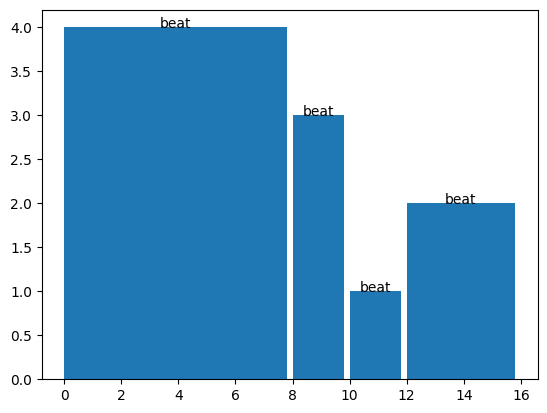

In [10]:
def rhythm_from_grammar(
    duration,    # the total duration (i.e. duration of the first interval)
    p_split,     # probability to split
    p_beat=None, # probability to produce a beat
    min_depth=2, # split at least this many times
    max_depth=5, # split at most this many times
):
    # if p_beat is not provided, assume we either split or produce a beat (no rests)
    if p_beat is None:
        p_beat = 1 - p_split
    # p_rest follows from: p_split + p_beat + p_rest = 1
    p_rest = 1 - (p_split + p_beat)
    # the probabilities as array
    p = np.array([p_beat, p_rest, p_split])
    # some checks
    assert np.all(p >= 0), p
    assert np.all(p <= 1), p
    assert p.sum() == 1, p

    # start with weight zero and use depth-based metrical weight
    rhythm = [TimeInterval(duration=duration, weight=0)]
    for depth in range(1, max_depth + 1):
        new_rhythm = []
        done = True
        for i in rhythm:
            # if interval is not splittable, just keep it
            # vvvvvvvvvvvvvvvvvvvvvvv
            if i.value is not None:
                new_rhythm.append(i)
                continue
            # ^^^^^^^^^^^^^^^^^^^^^^^

            # otherwise select one of the three operations
            # o = 0 --> beat
            # o = 1 --> rest
            # o = 2 --> split
            done = False
            # vvvvvvvvvvvvvvvvvvvvvvvvvv
            if depth < min_depth:
                o = 2
            elif depth >= max_depth:
                o = np.random.choice(2, p=p[:2]/p[:2].sum())
            else:
                o = np.random.choice(3, p=p)
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^

            # apply the operation and append
            # vvvvvvvvvvvvvvvvvvvvvvvvvv
            if o == 0:
                i.value = "beat"
                new_rhythm.append(i)
            elif i == 1:
                i.value = "rest"
                new_rhythm.append(i)
            else:
                i1 = TimeInterval(duration=i.duration / 2, weight=i.weight)
                i2 = TimeInterval(duration=i.duration / 2, weight=-depth)
                new_rhythm += [i1, i2]
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^
        rhythm = new_rhythm
        if done:
            break

    # shift weights to the positive range
    min_weight = min(i.weight for i in rhythm)
    for i in rhythm:
        i.weight = i.weight - min_weight + 1
        
    return rhythm

rhythm = rhythm_from_grammar(duration=16, p_split=0.6)
print(rhythm)
visualise_rhythm(rhythm)

### Create Audio

Adapt the code from above to work with the rhythms generated by the grammar.

[<beat:0.25|6>, <beat:0.25|1>, <beat:0.5|2>, <beat:1.0|3>, <beat:0.5|4>, <beat:0.5|2>, <beat:0.25|3>, <beat:0.25|1>, <beat:0.25|2>, <beat:0.25|1>, <beat:1.0|5>, <beat:0.5|3>, <beat:0.5|2>, <beat:0.25|4>, <beat:0.25|1>, <beat:0.5|2>, <beat:1.0|3>]


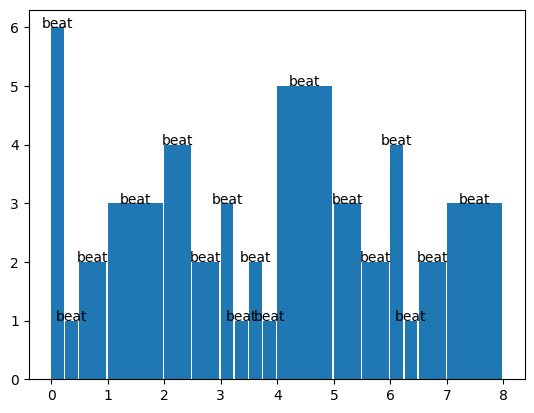

In [11]:
def beat_from_rhythm(rhythm):
    audio = None
    t = 0  # time
    for i in rhythm:
        # ignore rests (just update time and continue)
        # vvvvvvvvvvvvvvv
        if i.value == "rest":
            t += i.duration
            continue
        # ^^^^^^^^^^^^^^^

        # add sounds based on weight
        # vvvvvvvvvvvvvvv
        w = i.weight
        # bass drum
        if w >= 3:
            audio = mps.audio_add(bass_drum, t, audio)
        # hi-hat
        elif w <= 1:
            audio = mps.audio_add(hi_hat, t, audio)
        # snare
        else:
            audio = mps.audio_add(snare_drum, t, audio)
        # ^^^^^^^^^^^^^^^

        # update time
        # vvvvvvvvvvvvvv
        t += i.duration
        # ^^^^^^^^^^^^^^
    return audio

rhythm = rhythm_from_grammar(duration=8, p_split=0.6, min_depth=4, max_depth=6)
print(rhythm)
visualise_rhythm(rhythm)
mps.audio(beat_from_rhythm(rhythm))

## Rhythm and Melody

Write a function that takes a rhythm and a melody (in MIDI pitch) and generates the given melody played in the given rhythm.

**Hints:**
-  Caution: rests have to be filled with silence! You need to _asynchronously_ iterate through rhythm and melody.
-  Remember earlier practicals
   -  `pitchtypes.Enharmonic` gives you the frequency of MIDI pitch with `Enharmonic.Pitch(midi_pitch).freq()`.
   -  `muprocdurham.sound` has the `sound(frequency, duration)` function.
-  Silence is just sound with zero amplitude.

In [12]:
def rhythm_and_melody(rhythm, melody, show=True, play=True):
    # create a stream of audio snippets
    stream = []

    # iterate through melody and rhythm
    # and generate notes of correct pitch
    # and duration (or silence)
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    m_iter = iter(melody)
    for i in rhythm:
        beat = i.value == "beat"
        if beat:
            try:
                pitch = next(m_iter)
            except StopIteration:
                print("Melody too short!")
                break

        freq = Enharmonic.Pitch(pitch).freq() if beat else 1
        note = mps.render(mps.sound(freq, duration=i.duration)) * i.weight
        if beat:
            stream.append(note)
        else:
            stream.append(0. * note)  # silence
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # concatenate the audio snippets
    return np.concatenate(stream)

[<beat:1.0|6>, <beat:0.5|3>, <beat:0.25|2>, <beat:0.25|1>, <beat:0.25|4>, <beat:0.25|1>, <beat:0.5|2>, <beat:0.25|3>, <beat:0.25|1>, <beat:0.5|2>, <beat:1.0|5>, <beat:0.25|3>, <beat:0.25|1>, <beat:0.5|2>, <beat:1.0|4>, <beat:1.0|3>]


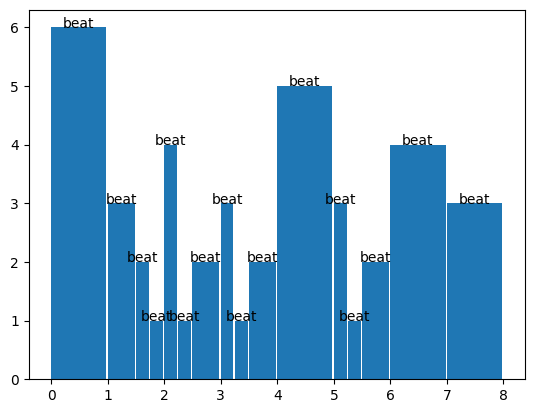

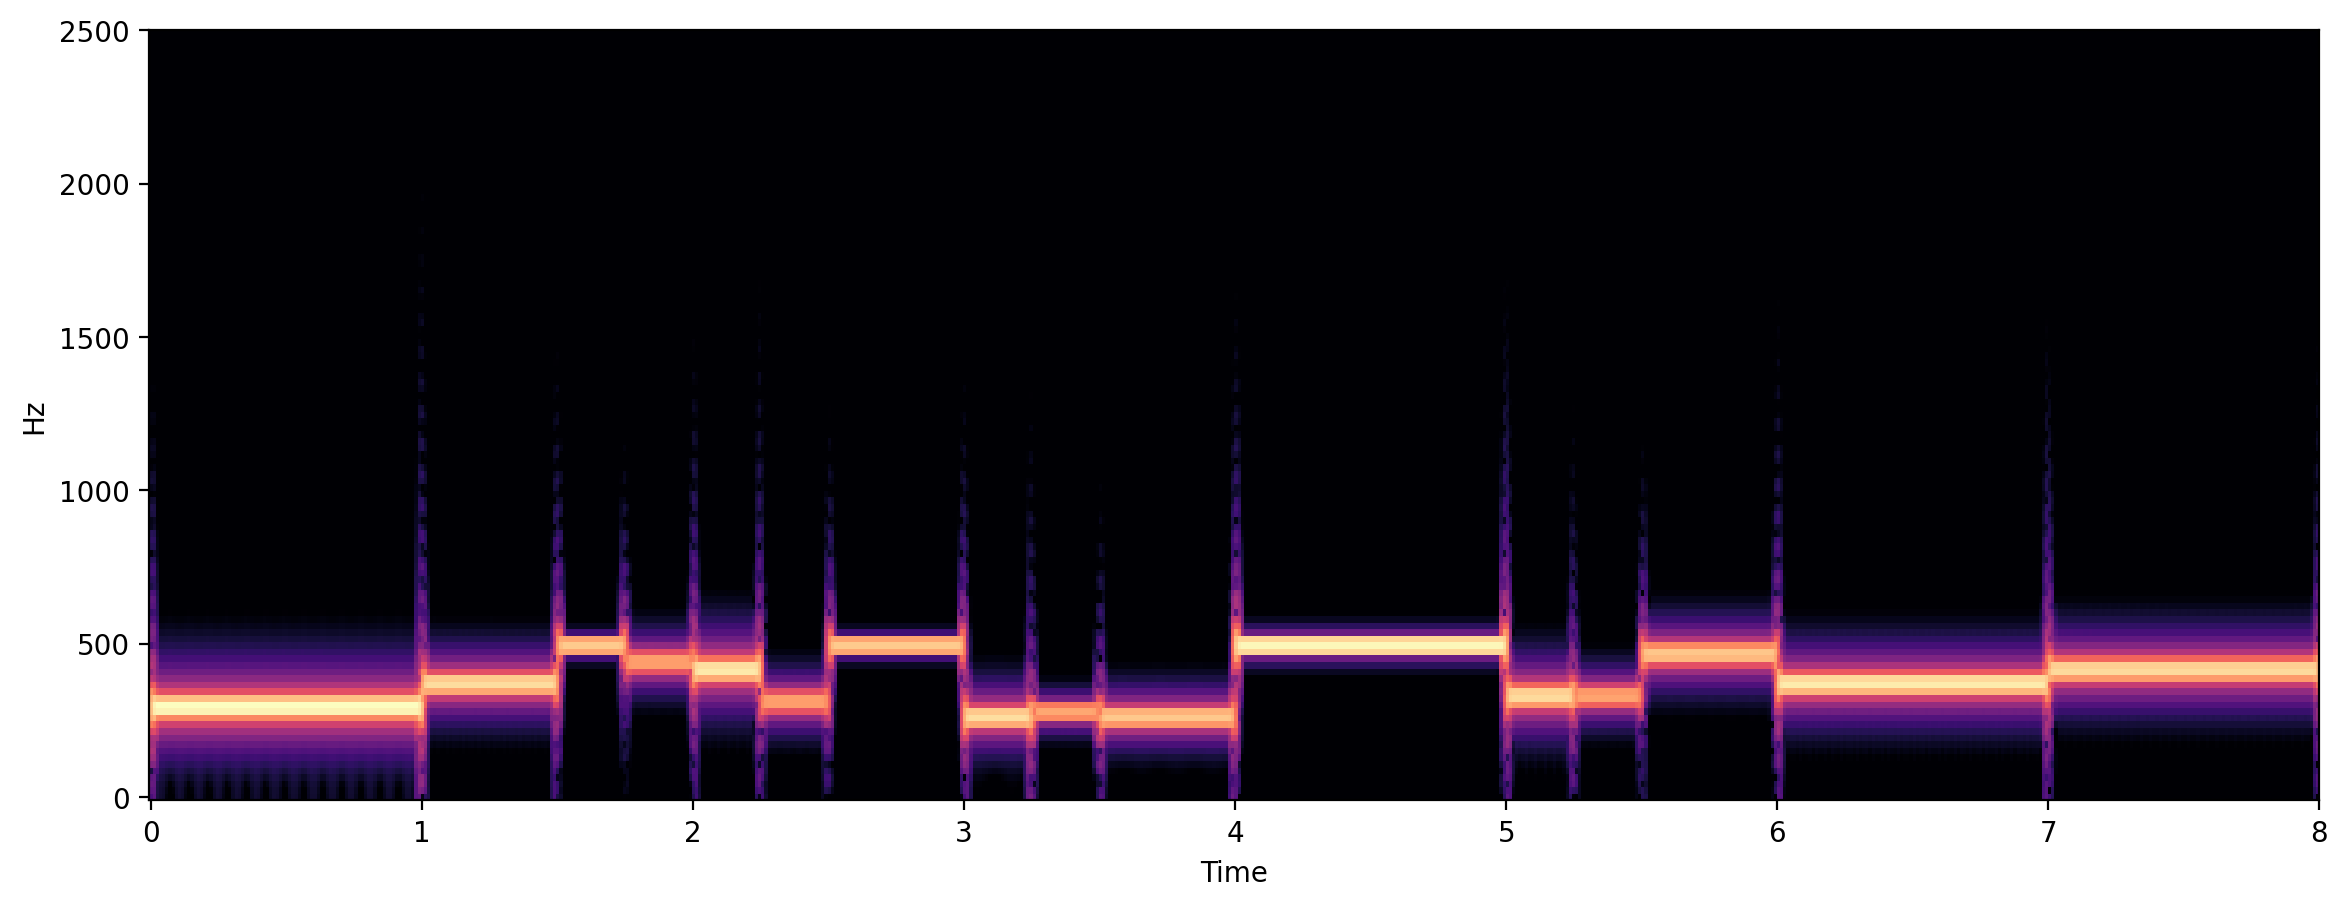

In [13]:
rhythm = rhythm_from_grammar(duration=8, p_split=0.6, min_depth=4, max_depth=6)
print(rhythm)
visualise_rhythm(rhythm)
audio = rhythm_and_melody(rhythm, melody=np.random.randint(60, 72, 100))
mps.spectrogram(audio, ylim=2500)
mps.audio(audio)

Now we can put everything together.

[<beat:1.0|6>, <beat:0.5|3>, <beat:0.25|2>, <beat:0.25|1>, <beat:0.25|4>, <beat:0.25|1>, <beat:0.25|2>, <beat:0.25|1>, <beat:0.25|3>, <beat:0.25|1>, <beat:0.25|2>, <beat:0.25|1>, <beat:0.5|5>, <beat:0.5|2>, <beat:1.0|3>, <beat:0.25|4>, <beat:0.25|1>, <beat:0.25|2>, <beat:0.25|1>, <beat:0.25|3>, <beat:0.25|1>, <beat:0.25|2>, <beat:0.25|1>]


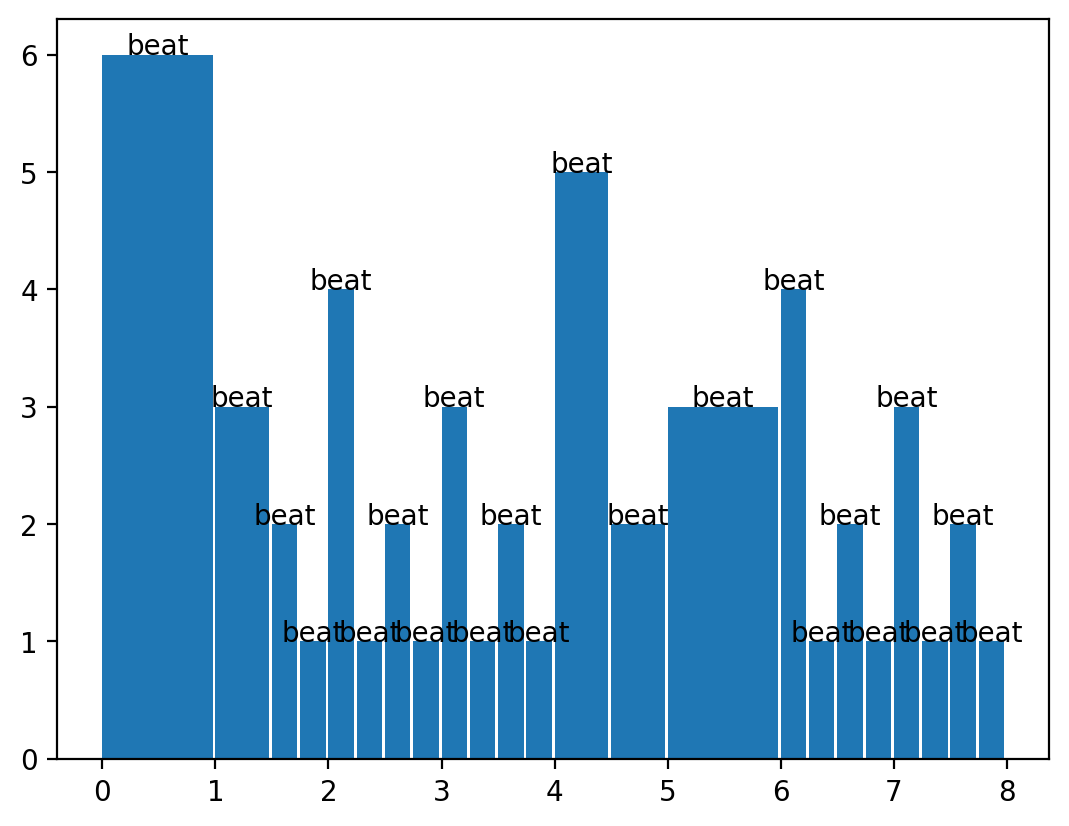

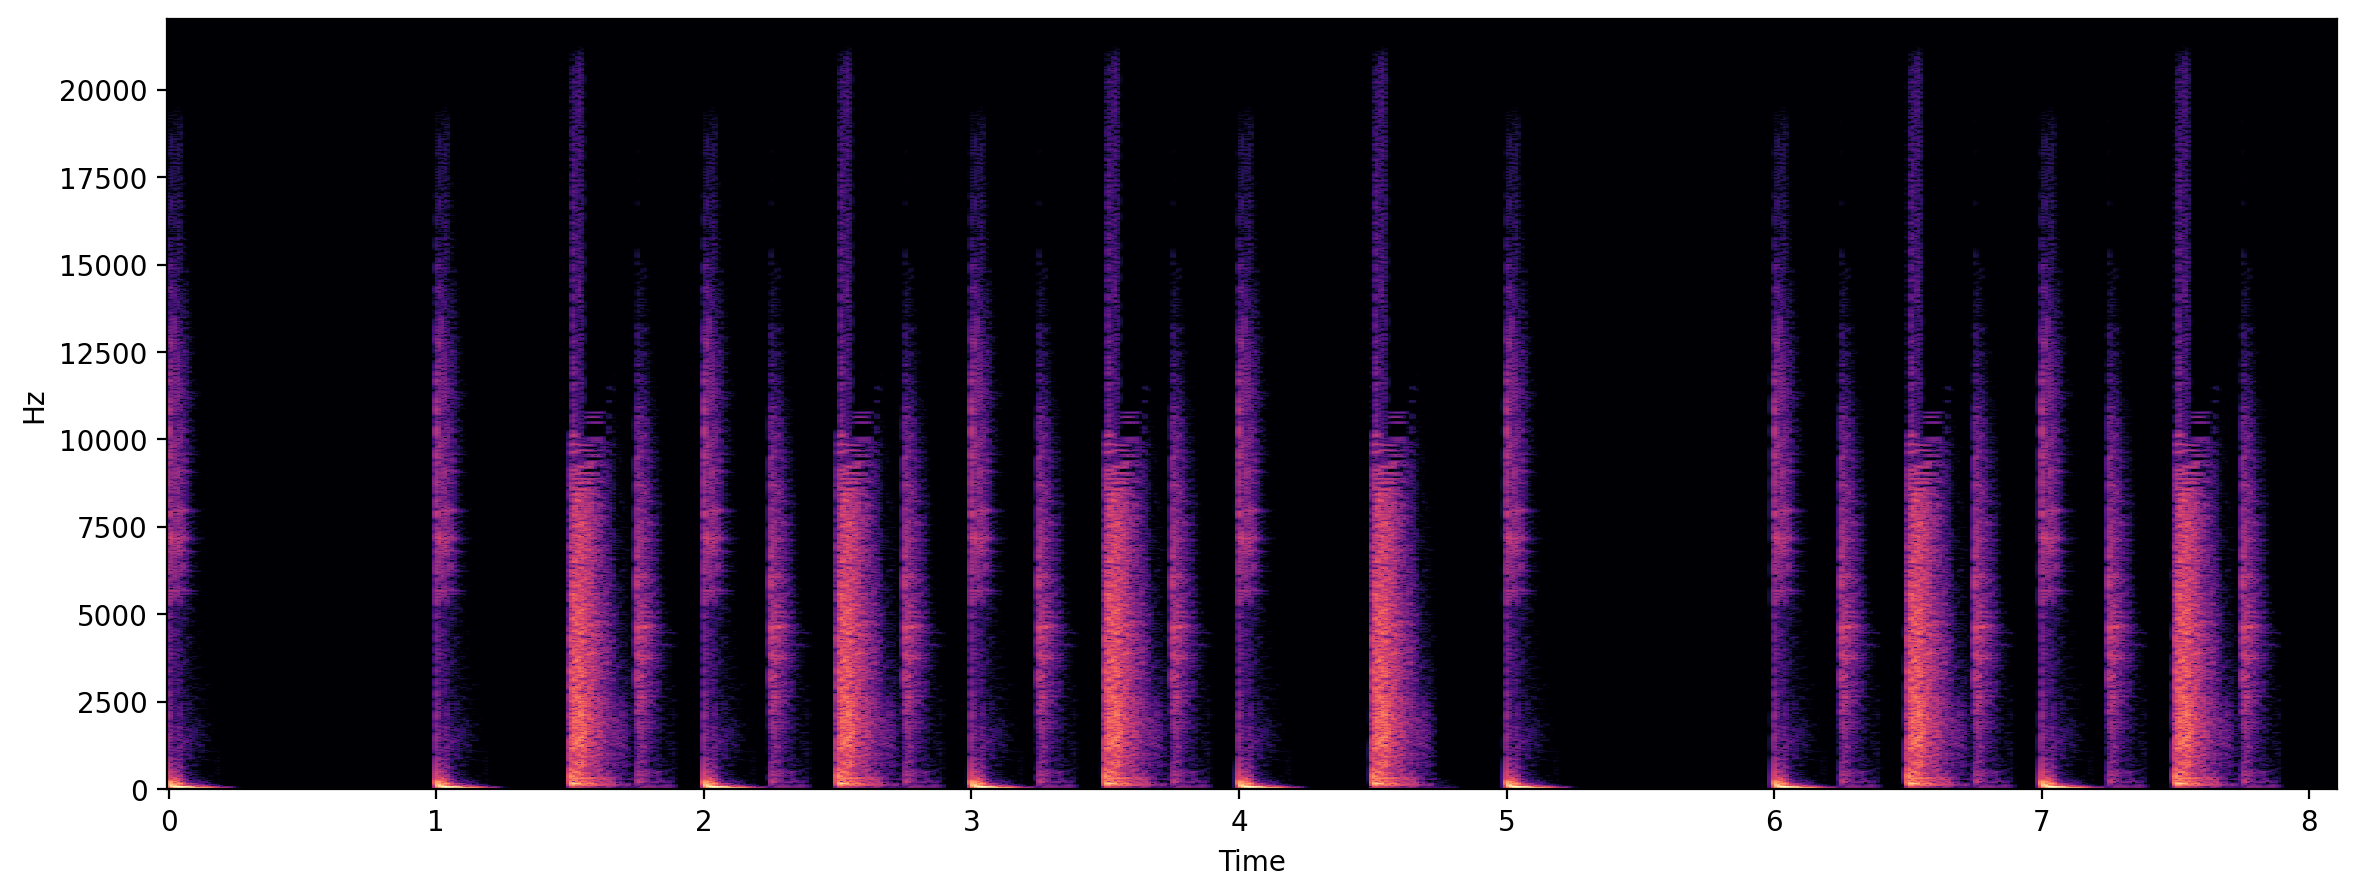

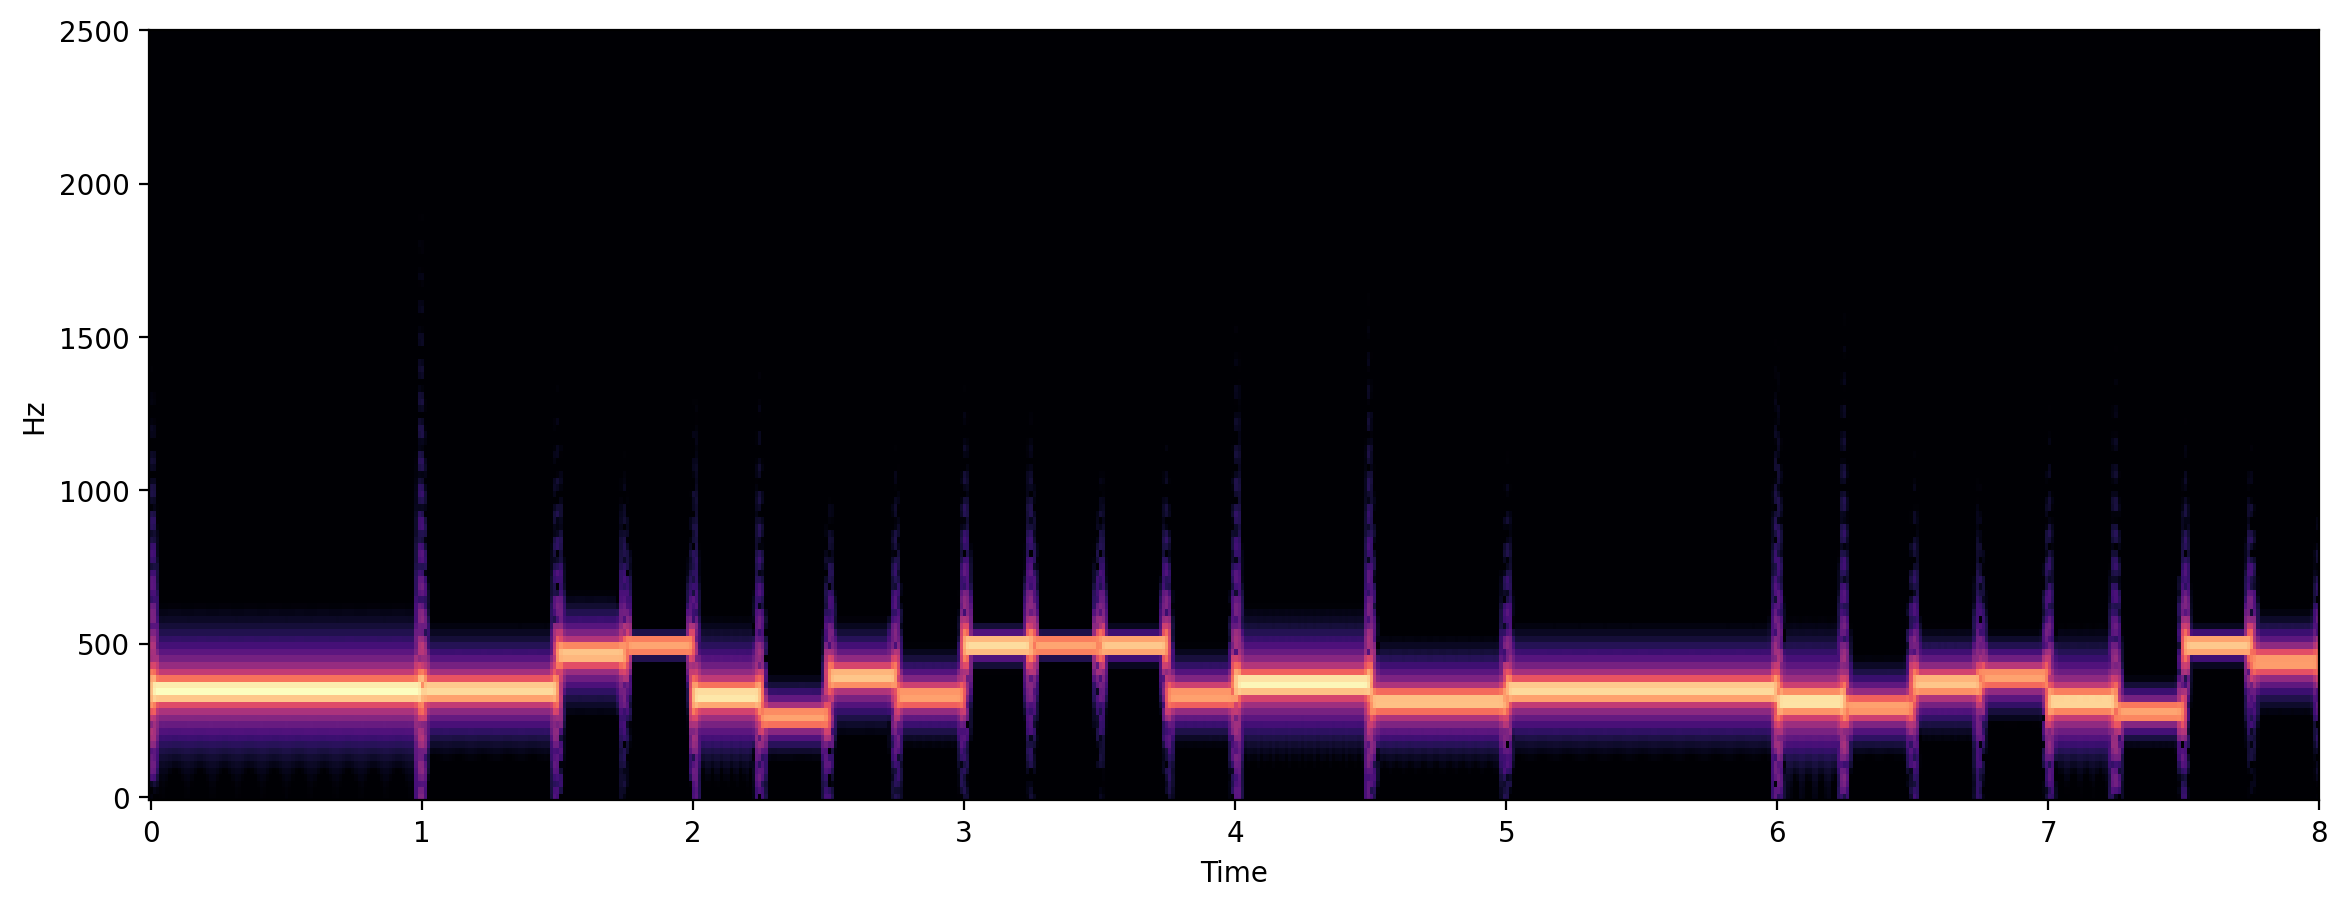

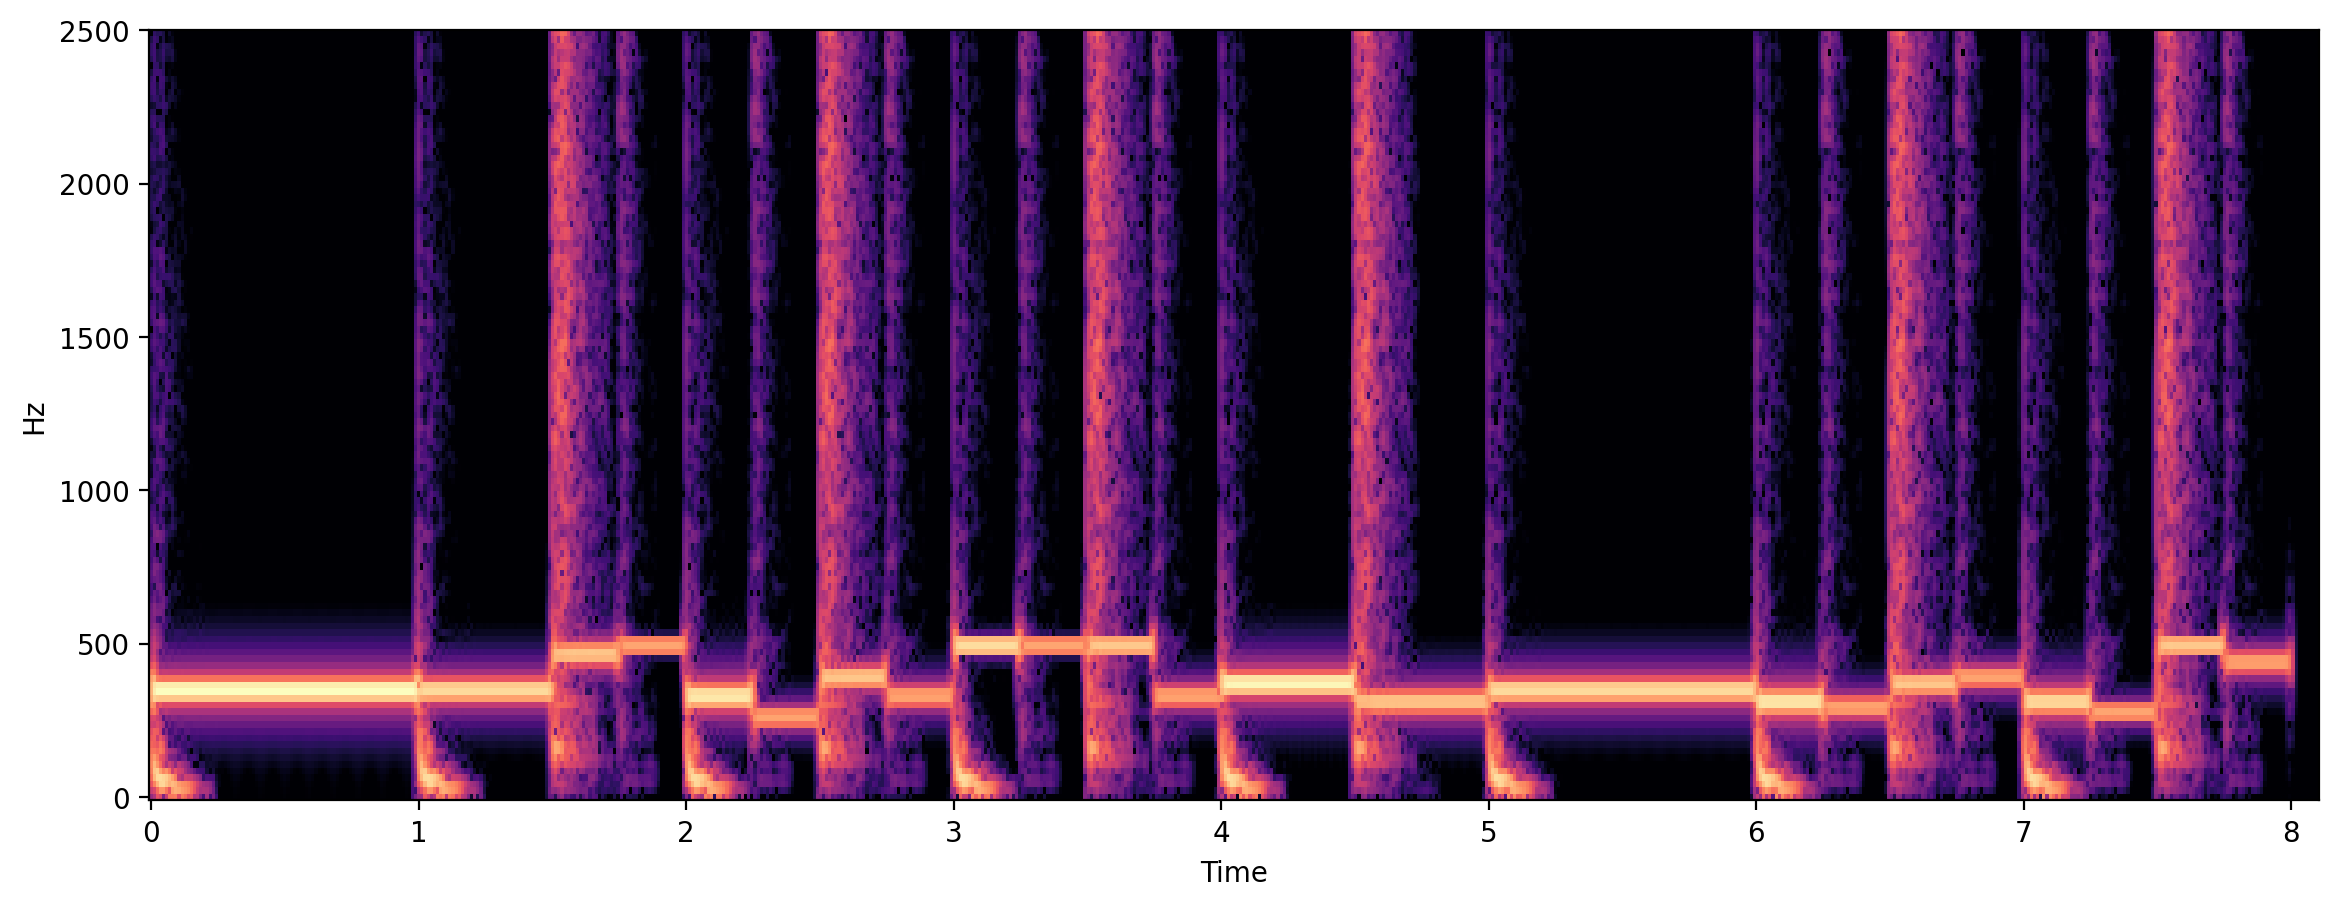

In [14]:
rhythm = rhythm_from_grammar(duration=8, p_split=0.6, min_depth=4, max_depth=6)
print(rhythm)
visualise_rhythm(rhythm)

beat = beat_from_rhythm(rhythm)
mps.spectrogram(beat)
mps.audio(beat)

melody = rhythm_and_melody(rhythm, melody=np.random.randint(60, 72, 100))
mps.spectrogram(melody, ylim=2500)
mps.audio(melody)

music = mps.render(mps.audio_add(wave=beat, audio=melody / 3, start_time=0))
mps.spectrogram(music, ylim=2500)
mps.audio(music)